In [2]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [20]:
# This function reads in a .dcm file, checks the important fields for our device, 
# and returns a numpy array of just the imaging data
def check_dicom(filename): 
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename) 
    img = np.array([])
    error_format = ''
    '''
    Checking the image modality. 
    Expected modalities:
    DX - Digital Radiography
    CT - Computed Tomography
    MR - Magnetic Resonance
    '''
    check_modality = False
    if (ds.Modality in ['DX', 'CT', 'MR']):
        check_modality = True
    else:
        error_format += 'Modality: ' + ds.Modality + '; '
    '''
    Checking body part
    Expecting value: CHEST
    '''
    check_body_part = False
    if(ds.BodyPartExamined == 'CHEST'):
        check_body_part = True
    else:
        error_format += 'Body Part: ' + ds.BodyPartExamined + '; '
    '''
    Checking patient position
    Expected values : AP or PA
    '''
    check_patient_position = False
    if(ds.PatientPosition in ['AP','PA']):
        check_patient_position = True
    else:
        error_format += 'Patient Position: ' + ds.PatientPosition + '; '
        
    # putting it all together    
    if(check_modality and check_body_part and check_patient_position):
        img = ds.pixel_array
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        return img, ds.StudyDescription
    else:
        print('format error:' + error_format + 'skipping...')
        return None, None
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img, img_size): 
    # normalization is done sample-wise, so std and mean should be calculated for each test image
    img = np.array(img).astype('float32')/255
    img = cv2.resize(img, (img_size, img_size))
    img = (img - np.mean(img))/np.std(img)
     # rescaling done after all other transformations
    img = np.expand_dims(img, axis=0)
    return img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path):
    
    return tf.keras.models.load_model(model_path)

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    prediction = 0
    predicted_labels = model.predict(img)
    pneumonia = predicted_labels[0][-1]
    if(pneumonia > thresh):
        prediction = 1
    
    return prediction 

Load file test1.dcm ...
Load file test2.dcm ...
Load file test3.dcm ...
Load file test4.dcm ...
format error:Body Part: RIBCAGE; skipping...
Load file test5.dcm ...
Load file test6.dcm ...
format error:Patient Position: XX; skipping...


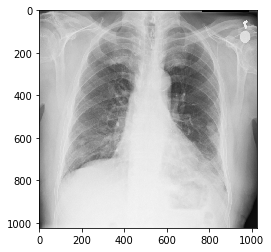

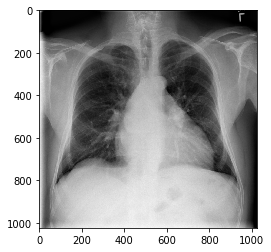

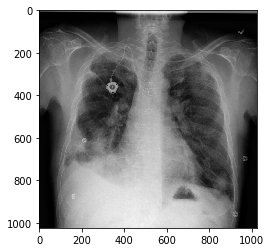

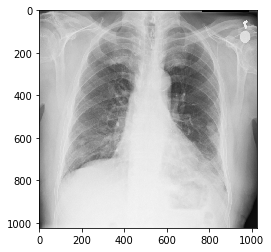

In [21]:
#
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']
for file_name in test_dicoms:
    
    img, finding = check_dicom(file_name)
    if img is None:
        continue
    plt.figure()
    plt.imshow(img)

In [7]:
# load model
model_path = 'model.inceptionresnetv2_good.h5'
my_model = load_model(model_path)

In [23]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

IMG_SIZE=256 # This might be different if you did not use vgg16

thresh = 0.3

# use the .dcm files to test your prediction
for i in test_dicoms:
    
    img = np.array([])
    img, finding = check_dicom(i)
    
    if img is None:
        print('..............................................')
        continue
        
    img_proc = preprocess_image(img,IMG_SIZE)
    pred = predict_image(my_model,img_proc,thresh)
    if(pred == 0):
        print('Pneumonia: Negative')
    else:
        print('Pneumonia: Positive')
    print('Actual Finding: ', finding)
    print('..............................................')

Load file test1.dcm ...
Pneumonia: Negative
Actual Finding:  No Finding
..............................................
Load file test2.dcm ...
Pneumonia: Negative
Actual Finding:  Cardiomegaly
..............................................
Load file test3.dcm ...
Pneumonia: Negative
Actual Finding:  Effusion
..............................................
Load file test4.dcm ...
format error:Body Part: RIBCAGE; skipping...
..............................................
Load file test5.dcm ...
Pneumonia: Negative
Actual Finding:  No Finding
..............................................
Load file test6.dcm ...
format error:Patient Position: XX; skipping...
..............................................
